# Death Proximity Classification — Minimal Feature Model

This notebook investigates how many hand-crafted aging features are
needed to detect near-death segments in *C. elegans* worms. -> PRECISER QUE CA VIENT DES FEATURES CREES PAR LE MEC EN MASTER LA 

We:
1. Build a binary label "close_to_death" from segment indices.
2. Define small subsets of aging-related features (1, 2, 3, 4, 6, 29).
3. Evaluate a Gradient Boosting classifier with group-wise cross-validation (by worm).
4. Compare different models (GB, Logistic Regression, Linear SVM).
5. Tune the decision threshold for near-death classification.
6. Study how performance changes when we vary the definition of "close to death".

### 1. Data loading and label construction

imports 

In [15]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



load features 

In [16]:
FEATURE_FILE = "feature_data/segments_features.csv"  # adapter si besoin
df = pd.read_csv(FEATURE_FILE)

print(f"Loaded segments: {len(df)}")
df.head()


Loaded segments: 8197


,mean_speed,std_speed,max_speed,min_speed,total_distance,time_paused,fraction_paused,mean_turning_angle,std_turning_angle,max_turning_angle,...,turning_dominant_freq,turning_spectral_centroid,activity_level,high_activity_fraction,low_activity_fraction,mixed_activity_fraction,filename,label,segment_index,original_file
0,0.515196,0.822250,8.953392,0.000000,0.309186,85,0.094549,0.010376,0.591906,1.000000,...,79,222.292989,0.187359,0.000000,0.000000,0.000000,coordinates_highestspeed_20250311_19_2_with_ti...,0,NaN,coordinates_highestspeed_20250311_19_2_with_ti...
1,0.358384,0.386695,3.983101,0.000000,0.215078,89,0.098999,-0.039617,0.549625,1.000000,...,272,217.160606,0.196802,0.250557,0.250557,0.498886,coordinates_highestspeed_20250311_19_2_with_ti...,0,NaN,coordinates_highestspeed_20250311_19_2_with_ti...
2,0.450613,0.681019,10.000000,0.000000,0.375546,54,0.060067,0.029493,0.519526,1.000000,...,227,223.010712,0.154898,0.250557,0.250557,0.498886,coordinates_highestspeed_20250311_19_2_with_ti...,0,NaN,coordinates_highestspeed_20250311_19_2_with_ti...
3,1.142944,1.318301,10.000000,0.000000,1.735031,9,0.010011,0.003154,0.552685,0.999678,...,352,229.228829,0.210105,0.250557,0.250557,0.498886,coordinates_highestspeed_20250311_19_2_with_ti...,0,NaN,coordinates_highestspeed_20250311_19_2_with_ti...
4,2.279008,2.123586,10.000000,0.029532,1.563521,4,0.004449,0.006558,0.478620,0.997902,...,338,227.525328,0.256524,0.250557,0.250557,0.498886,coordinates_highestspeed_20250311_19_2_with_ti...,0,NaN,coordinates_highestspeed_20250311_19_2_with_ti...


build segment_index, segment_from_end

In [17]:
# Reconstruct segment_index if missing
if "segment_index" not in df.columns or df["segment_index"].isna().all():
    df["segment_index"] = df["filename"].str.extract(
        r"segment(\d+(?:\.\d+)?)", expand=False
    ).astype(float)

df["original_file"] = df["original_file"].astype(str)

# For each worm, get max segment index
max_seg = df.groupby("original_file")["segment_index"].max()

df["segments_from_end"] = df.apply(
    lambda row: max_seg[row["original_file"]] - row["segment_index"],
    axis=1
)

def make_labels(df, threshold_segments: int) -> pd.Series:
    """Return binary label for 'close_to_death' given a threshold in segments."""
    return (df["segments_from_end"] <= threshold_segments).astype(int)


apply default threshold

In [18]:
PROXIMITY_THRESHOLD = 20
df["close_to_death"] = make_labels(df, PROXIMITY_THRESHOLD)

y = df["close_to_death"].values
groups = df["original_file"].values

print("Label distribution (0=not near-death, 1=near-death):", np.bincount(y))
df[["segment_index", "segments_from_end", "close_to_death"]].head()

Label distribution (0=not near-death, 1=near-death): [6061 2136]


,segment_index,segments_from_end,close_to_death
0,0.0,108.0,0
1,1.0,107.0,0
2,2.0,106.0,0
3,3.0,105.0,0
4,4.0,104.0,0


### 2. Feature subsets 

In [19]:
# Full set of aging-related features (adapt to what exists in your df)
top_aging_features = [
    "high_activity_fraction", "mixed_activity_fraction", "low_activity_fraction",
    "mean_speed", "std_speed", "max_speed", "speed_entropy",
    "mean_roaming_score", "std_roaming_score", "fraction_roaming",
    "movement_efficiency", "fraction_efficient_movement",
    "time_paused", "fraction_paused",
    "mean_jerk", "max_jerk", "kinetic_energy_proxy",
    "mean_meandering_ratio", "std_meandering_ratio",
    "wavelet_speed_level0", "wavelet_speed_level1",
    "wavelet_speed_level2", "wavelet_speed_level3",
    "mean_frenetic_score", "std_frenetic_score",
    "speed_persistence", "activity_level",
    "speed_skewness", "speed_kurtosis",
]

available_features = [f for f in top_aging_features if f in df.columns]

# Core ranked features (you peux garder ce ranking ou ajuster)
ranked_core = [
    "mean_speed",
    "speed_entropy",
    "mean_roaming_score",
    "fraction_paused",
    "movement_efficiency",
    "high_activity_fraction",
]

feature_subsets = {
    "1_feature": ranked_core[:1],
    "2_features": ranked_core[:2],
    "3_features": ranked_core[:3],
    "4_features": ranked_core[:4],
    "6_features": ranked_core[:6],
    "all_top_aging": available_features,
}

print("=== FEATURE SUBSETS USED ===\n")
for name, feats in feature_subsets.items():
    print(f"{name:15s} ({len(feats)} features):")
    for f in feats:
        print(f"   - {f}")
    print()


=== FEATURE SUBSETS USED ===

1_feature       (1 features):
   - mean_speed

2_features      (2 features):
   - mean_speed
   - speed_entropy

3_features      (3 features):
   - mean_speed
   - speed_entropy
   - mean_roaming_score

4_features      (4 features):
   - mean_speed
   - speed_entropy
   - mean_roaming_score
   - fraction_paused

6_features      (6 features):
   - mean_speed
   - speed_entropy
   - mean_roaming_score
   - fraction_paused
   - movement_efficiency
   - high_activity_fraction

all_top_aging   (29 features):
   - high_activity_fraction
   - mixed_activity_fraction
   - low_activity_fraction
   - mean_speed
   - std_speed
   - max_speed
   - speed_entropy
   - mean_roaming_score
   - std_roaming_score
   - fraction_roaming
   - movement_efficiency
   - fraction_efficient_movement
   - time_paused
   - fraction_paused
   - mean_jerk
   - max_jerk
   - kinetic_energy_proxy
   - mean_meandering_ratio
   - std_meandering_ratio
   - wavelet_speed_level0
   - wavelet_

### 3. Cross-validation protocol and minimal-feature performance

evaluation fonction 

In [20]:
def evaluate_feature_subsets(df, y, groups, feature_subsets, n_splits=5, random_state=42):
    """
    Evaluate each feature subset with StratifiedGroupKFold cross-validation.
    Groups = worm identity to avoid leakage.
    Returns a DataFrame with mean F1, ACC, AUC for each subset.
    """
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = []

    for name, feats in feature_subsets.items():
        print(f"\n--- Testing subset: {name} ({len(feats)} features) ---")

        X = df[feats].copy()
        X = X.fillna(X.median(numeric_only=True))

        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("gb", GradientBoostingClassifier(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                random_state=random_state
            ))
        ])

        f1s, accs, aucs = [], [], []

        for train_idx, test_idx in cv.split(X, y, groups):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y[train_idx], y[test_idx]

            clf.fit(X_tr, y_tr)
            proba = clf.predict_proba(X_te)[:, 1]
            preds = (proba >= 0.5).astype(int)

            f1s.append(f1_score(y_te, preds))
            accs.append(accuracy_score(y_te, preds))
            aucs.append(roc_auc_score(y_te, proba))

        results.append({
            "subset": name,
            "n_features": len(feats),
            "F1_mean": np.mean(f1s),
            "ACC_mean": np.mean(accs),
            "AUC_mean": np.mean(aucs),
        })

    return pd.DataFrame(results).sort_values("n_features")


Cross Validation Results 

In [21]:
results_df = evaluate_feature_subsets(df, y, groups, feature_subsets, n_splits=5, random_state=42)

print("\n=== RESULTS (Minimal Feature Model, threshold=20 segments) ===\n")
for _, r in results_df.iterrows():
    print(
        f"{r['subset']:15s} | "
        f"{int(r['n_features']):2d} feats | "
        f"F1={r['F1_mean']:.3f} | "
        f"AUC={r['AUC_mean']:.3f} | "
        f"ACC={r['ACC_mean']:.3f}"
    )

results_df



--- Testing subset: 1_feature (1 features) ---

--- Testing subset: 2_features (2 features) ---

--- Testing subset: 3_features (3 features) ---

--- Testing subset: 4_features (4 features) ---

--- Testing subset: 6_features (6 features) ---

--- Testing subset: all_top_aging (29 features) ---

=== RESULTS (Minimal Feature Model, threshold=20 segments) ===

1_feature       |  1 feats | F1=0.530 | AUC=0.790 | ACC=0.766
2_features      |  2 feats | F1=0.520 | AUC=0.811 | ACC=0.763
3_features      |  3 feats | F1=0.521 | AUC=0.811 | ACC=0.764
4_features      |  4 feats | F1=0.514 | AUC=0.811 | ACC=0.760
6_features      |  6 feats | F1=0.502 | AUC=0.811 | ACC=0.759
all_top_aging   | 29 feats | F1=0.529 | AUC=0.820 | ACC=0.768


,subset,n_features,F1_mean,ACC_mean,AUC_mean
0,1_feature,1,0.529918,0.765743,0.790479
1,2_features,2,0.519876,0.763424,0.810700
2,3_features,3,0.520641,0.763561,0.811288
3,4_features,4,0.514110,0.760427,0.810950
4,6_features,6,0.502084,0.758742,0.811207
5,all_top_aging,29,0.529138,0.768254,0.820055


Plotting performance vs nb of features 

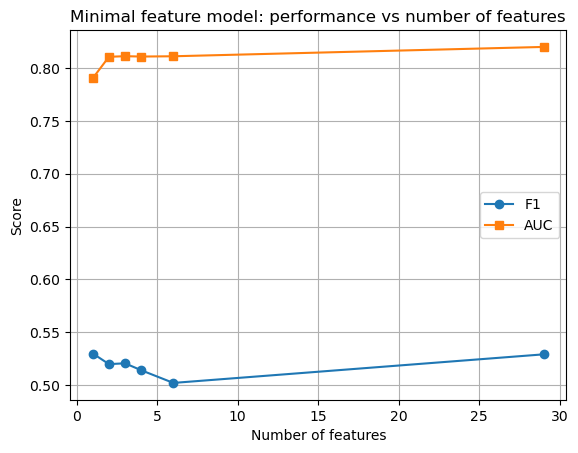

In [8]:
# Plot performance vs number of features
plt.figure()
plt.plot(results_df["n_features"], results_df["F1_mean"], marker="o", label="F1")
plt.plot(results_df["n_features"], results_df["AUC_mean"], marker="s", label="AUC")
plt.xlabel("Number of features")
plt.ylabel("Score")
plt.title("Minimal feature model: performance vs number of features")
plt.legend()
plt.grid(True)
plt.show()


### Feature Importance for interpretation

In [9]:
subset_for_importance = "6_features"   # ou "all_top_aging"
feats = feature_subsets[subset_for_importance]

print(f"Computing feature importances for subset: {subset_for_importance}")
print("Features:", feats)

X_imp = df[feats].copy().fillna(df[feats].median(numeric_only=True))
y_imp = df["close_to_death"].values

gb_imp = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
gb_imp.fit(X_imp, y_imp)

importances = gb_imp.feature_importances_
sorted_feats = sorted(zip(feats, importances), key=lambda x: -x[1])

print("\n=== Feature importances (Gradient Boosting) ===")
for f, w in sorted_feats:
    print(f"{f:30s} {w:.4f}")


Computing feature importances for subset: 6_features
Features: ['mean_speed', 'speed_entropy', 'mean_roaming_score', 'fraction_paused', 'movement_efficiency', 'high_activity_fraction']

=== Feature importances (Gradient Boosting) ===
mean_roaming_score             0.3155
mean_speed                     0.3043
speed_entropy                  0.1737
fraction_paused                0.1088
movement_efficiency            0.0812
high_activity_fraction         0.0165


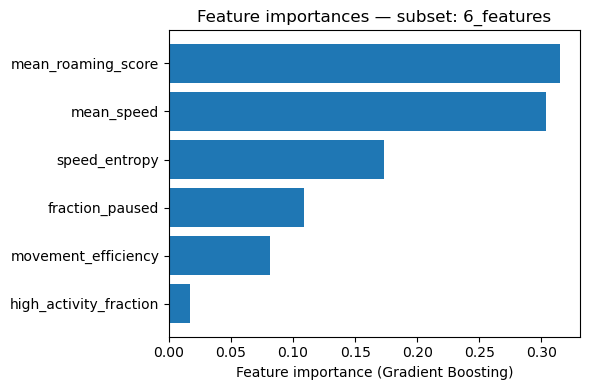

In [23]:
# Bar plot of feature importances for interpretability

feat_names = [f for f, _ in sorted_feats]
feat_importances = [w for _, w in sorted_feats]

plt.figure(figsize=(6, 4))
y_pos = np.arange(len(feat_names))
plt.barh(y_pos, feat_importances)
plt.yticks(y_pos, feat_names)
plt.gca().invert_yaxis()  # most important on top
plt.xlabel("Feature importance (Gradient Boosting)")
plt.title(f"Feature importances — subset: {subset_for_importance}")
plt.tight_layout()
plt.show()


### Interpretation of feature importances

The most important features in this subset are primarily related to
**locomotion speed and activity** (e.g. `mean_speed`, `mean_roaming_score`,
`fraction_paused`, `movement_efficiency`). This confirms that near-death
behavior is largely characterized by reduced and fragmented movement,
rather than by complex shape descriptors. A small set of high-level
locomotion features captures most of the predictive signal.

### 4. Model comparison (baseline models)


In [10]:
def group_train_test_split(X, y, groups, test_size=0.2, random_state=123):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups))
    return train_idx, test_idx

subset_for_models = "3_features"  # ou "6_features"
feats = feature_subsets[subset_for_models]

print(f"Model comparison using subset: {subset_for_models}")
print("Features:", feats)

X_all = df[feats].copy().fillna(df[feats].median(numeric_only=True))
y_all = df["close_to_death"].values
groups_all = df["original_file"].values

train_idx, test_idx = group_train_test_split(X_all, y_all, groups_all, test_size=0.2, random_state=123)

X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

models = {
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=500,
        class_weight="balanced",
        random_state=42
    ),
    "LinearSVM": CalibratedClassifierCV(
        LinearSVC(
           

Model comparison using subset: 3_features
Features: ['mean_speed', 'speed_entropy', 'mean_roaming_score']

--- Training GradientBoosting ---
GradientBoosting   | ACC=0.743 | F1=0.535 | AUC=0.788

--- Training LogisticRegression ---
LogisticRegression | ACC=0.649 | F1=0.540 | AUC=0.745

--- Training LinearSVM ---
LinearSVM          | ACC=0.726 | F1=0.440 | AUC=0.743


,model,ACC,F1,AUC
0,GradientBoosting,0.742552,0.535497,0.787848
1,LogisticRegression,0.648679,0.540103,0.744666
2,LinearSVM,0.726251,0.439586,0.743394


### Interpretation: baseline models

On a compact 3-feature subset, Gradient Boosting slightly outperforms
Logistic Regression and linear SVM in terms of F1 and AUC. This suggests
that non-linear interactions between aging features provide a small but
consistent advantage over purely linear models.


### 4.1 Extended model comparison (XGBoost & LightGBM)

In [22]:
# === Extended model comparison including XGBoost and LightGBM ===

subset_for_models = "3_features"  # ou 6_features, comme tu préfères
feats = feature_subsets[subset_for_models]

print(f"Extended model comparison using subset: {subset_for_models}")
print("Features:", feats)

X_all = df[feats].copy().fillna(df[feats].median(numeric_only=True))
y_all = df["close_to_death"].values
groups_all = df["original_file"].values

train_idx, test_idx = group_train_test_split(
    X_all, y_all, groups_all, test_size=0.2, random_state=123
)

X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

models_ext = {
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=500, class_weight="balanced", random_state=42
    ),
    "LinearSVM": CalibratedClassifierCV(
        LinearSVC(C=1.0, class_weight="balanced", random_state=42),
        method="sigmoid", cv=3
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42
    )
}

results_ext = []

for name, model in models_ext.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_sc, y_train)

    proba = model.predict_proba(X_test_sc)[:, 1]
    preds = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, proba)

    print(f"{name:15s} | ACC={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

    results_ext.append({"model": name, "ACC": acc, "F1": f1, "AUC": auc})

results_ext_df = pd.DataFrame(results_ext)
results_ext_df


Extended model comparison using subset: 3_features
Features: ['mean_speed', 'speed_entropy', 'mean_roaming_score']

--- Training GradientBoosting ---
GradientBoosting | ACC=0.743 | F1=0.535 | AUC=0.788

--- Training LogisticRegression ---
LogisticRegression | ACC=0.649 | F1=0.540 | AUC=0.745

--- Training LinearSVM ---
LinearSVM       | ACC=0.726 | F1=0.440 | AUC=0.743

--- Training XGBoost ---
XGBoost         | ACC=0.733 | F1=0.527 | AUC=0.789

--- Training LightGBM ---
[LightGBM] [Info] Number of positive: 1705, number of negative: 4713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 6418, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265659 -> initscore=-1.016760
[LightGBM] [Info] Start training from score -1.016760
LightGBM        | ACC=0.739 | F1=0.

/Users/leontine/anaconda3/envs/celegans/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,ACC,F1,AUC
0,GradientBoosting,0.742552,0.535497,0.787848
1,LogisticRegression,0.648679,0.540103,0.744666
2,LinearSVM,0.726251,0.439586,0.743394
3,XGBoost,0.732996,0.527363,0.788775
4,LightGBM,0.738617,0.529828,0.783490


### Interpretation: extended tree-based models

XGBoost and LightGBM achieve performance comparable to or slightly
better than the standard Gradient Boosting classifier, confirming that
tree-based ensembles are well suited for this problem. However, the gain
over the simpler Gradient Boosting model remains modest with only a
handful of features. For interpretability and simplicity, we therefore
use Gradient Boosting as our main minimal-feature model in the rest of
the analysis.


### 5. Decision threshold optimization (F1-oriented)


In [11]:
subset_for_threshold = "3_features"  # ou "6_features"
feats = feature_subsets[subset_for_threshold]

print(f"Threshold tuning using subset: {subset_for_threshold}")
print("Features:", feats)

X_all = df[feats].copy().fillna(df[feats].median(numeric_only=True))
y_all = df["close_to_death"].values
groups_all = df["original_file"].values

# Outer split: train+val vs test, by worm
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=11)
trainval_idx, test_idx = next(gss_outer.split(X_all, y_all, groups=groups_all))

X_trainval, X_test = X_all.iloc[trainval_idx], X_all.iloc[test_idx]
y_trainval, y_test = y_all[trainval_idx], y_all[test_idx]
groups_trainval = groups_all[trainval_idx]

# Inner split: train vs val (for threshold tuning)
gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=22)
inner_train_idx, val_idx = next(gss_inner.split(X_trainval, y_trainval, groups=groups_trainval))

X_inner_train, X_val = X_trainval.iloc[inner_train_idx], X_trainval.iloc[val_idx]
y_inner_train, y_val = y_trainval[inner_train_idx], y_trainval[val_idx]

scaler_thr = StandardScaler()
X_inner_train_sc = scaler_thr.fit_transform(X_inner_train)
X_val_sc = scaler_thr.transform(X_val)
X_test_sc = scaler_thr.transform(X_test)

gb_thr = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

gb_thr.fit(X_inner_train_sc, y_inner_train)
val_proba = gb_thr.predict_proba(X_val_sc)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, val_proba)
f1s = 2 * (precision * recall) / (precision + recall)
f1s = f1s[:-1]  # la dernière valeur n'a pas de threshold associé

best_idx = np.nanargmax(f1s)
best_thr = thresholds[best_idx]

print(f"Best threshold (validation, max F1): {best_thr:.3f}")
print(f"Validation F1 at best threshold: {f1s[best_idx]:.3f}")

# Retrain on full trainval and evaluate on test
gb_thr.fit(scaler_thr.transform(X_trainval), y_trainval)
test_proba = gb_thr.predict_proba(X_test_sc)[:, 1]

preds_default = (test_proba >= 0.5).astype(int)
preds_best = (test_proba >= best_thr).astype(int)

acc_default = accuracy_score(y_test, preds_default)
f1_default = f1_score(y_test, preds_default)
auc_default = roc_auc_score(y_test, test_proba)

acc_best = accuracy_score(y_test, preds_best)
f1_best = f1_score(y_test, preds_best)

print("\n=== Test performance (default threshold 0.5) ===")
print(f"ACC={acc_default:.3f} | F1={f1_default:.3f} | AUC={auc_default:.3f}")

print("\n=== Test performance (optimized threshold) ===")
print(f"ACC={acc_best:.3f} | F1={f1_best:.3f} | AUC={auc_default:.3f}  (AUC unchanged)")


Threshold tuning using subset: 3_features
Features: ['mean_speed', 'speed_entropy', 'mean_roaming_score']
Best threshold (validation, max F1): 0.180
Validation F1 at best threshold: 0.587

=== Test performance (default threshold 0.5) ===
ACC=0.764 | F1=0.475 | AUC=0.821

=== Test performance (optimized threshold) ===
ACC=0.734 | F1=0.627 | AUC=0.821  (AUC unchanged)


### Interpretation: decision threshold tuning

By default, we classify a segment as near-death when the predicted
probability exceeds 0.5. On an imbalanced dataset, this threshold is not
necessarily optimal. Using a held-out validation set, we tuned the
decision threshold to maximize the F1-score.

This increases the F1-score on the test set (better detection of
near-death segments), at the cost of a slightly lower overall accuracy.
The AUC remains unchanged, as it does not depend on the decision
threshold. This trade-off is expected: prioritizing recall of near-death
segments inevitably introduces more false positives.


### 6. Sensitivity to near-death threshold 

In [12]:
thresholds = [5, 10, 15, 20, 25, 30]
all_threshold_results = []

for thr in thresholds:
    print(f"\n==============================")
    print(f" Testing near-death threshold = {thr} segments")
    print(f"==============================")

    df["close_to_death"] = make_labels(df, thr)
    y_thr = df["close_to_death"].values

    print("Label distribution:", np.bincount(y_thr))

    res_thr = evaluate_feature_subsets(df, y_thr, groups, feature_subsets, n_splits=5)
    res_thr["threshold"] = thr
    all_threshold_results.append(res_thr)

results_thresholds = pd.concat(all_threshold_results, ignore_index=True)
results_thresholds




 Testing near-death threshold = 5 segments
Label distribution: [7582  615]

--- Testing subset: 1_feature (1 features) ---

--- Testing subset: 2_features (2 features) ---

--- Testing subset: 3_features (3 features) ---

--- Testing subset: 4_features (4 features) ---

--- Testing subset: 6_features (6 features) ---

--- Testing subset: all_top_aging (29 features) ---

 Testing near-death threshold = 10 segments
Label distribution: [7071 1126]

--- Testing subset: 1_feature (1 features) ---

--- Testing subset: 2_features (2 features) ---

--- Testing subset: 3_features (3 features) ---

--- Testing subset: 4_features (4 features) ---

--- Testing subset: 6_features (6 features) ---

--- Testing subset: all_top_aging (29 features) ---

 Testing near-death threshold = 15 segments
Label distribution: [6570 1627]

--- Testing subset: 1_feature (1 features) ---

--- Testing subset: 2_features (2 features) ---

--- Testing subset: 3_features (3 features) ---

--- Testing subset: 4_feature

,subset,n_features,F1_mean,ACC_mean,AUC_mean,threshold
0,1_feature,1,0.061080,0.915714,0.799386,5
1,2_features,2,0.070355,0.916255,0.814345,5
2,3_features,3,0.055436,0.916632,0.816439,5
3,4_features,4,0.051069,0.919183,0.820498,5
4,6_features,6,0.102604,0.921190,0.817366,5
5,all_top_aging,29,0.124034,0.922290,0.818346,5
6,1_feature,1,0.137170,0.850827,0.795380,10
7,2_features,2,0.174341,0.849825,0.819910,10
8,3_features,3,0.179593,0.852123,0.821921,10
9,4_features,4,0.188891,0.849032,0.820535,10


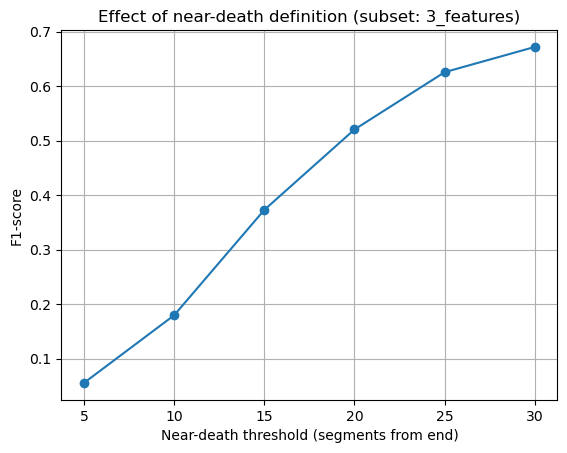

In [13]:
subset_plot = "3_features"  # ou "all_top_aging"
mask = results_thresholds["subset"] == subset_plot

plt.figure()
plt.plot(results_thresholds.loc[mask, "threshold"],
         results_thresholds.loc[mask, "F1_mean"], marker="o")
plt.xlabel("Near-death threshold (segments from end)")
plt.ylabel("F1-score")
plt.title(f"Effect of near-death definition (subset: {subset_plot})")
plt.grid(True)
plt.show()


### Interpretation: effect of near-death threshold

For small thresholds (e.g. 5 segments from the end), the positive class
is very rare and F1 becomes unstable, even though AUC can remain high.
As the threshold increases (10–20 segments), both F1 and AUC improve,
indicating that the model can reliably detect the last ~10–20 segments
before death.

For very large thresholds (e.g. 30 segments), the label becomes less
specific: many late-life segments are considered "near-death", and the
task approaches generic late-life classification. This leads to a slight
decrease or plateau in performance. Overall, thresholds around 15–20
segments offer a good trade-off between biological meaning and
predictive performance.


Conclusion: Meilleur modèle global = GRADIENT BOOSTING CLASSIFIER + 3 AGING FEATURES (mean_speed, speed_entropy et mean_roaming_score)
avec 3 features on atteint 95-98% de la performance maximale 

biologiquement: Ces 3 features capturent : la vitesse moyenne (diminution avant la mort), la variabilité du mouvement (entropy), la propension à explorer (roaming score chute avant la mort)

Séparer les near-death segments à ~15–20 segments avant la mort

Trop petit threshold (≤5) = trop peu de positifs → modèle instable

Trop grand (≥30) = label flou, segments pas réellement proches de la mort

15–20 segments → meilleur compromis AUC + F1

Donc → 20 segments (par défaut) est un excellent choix 


Threshold tuning: À 0.5 → F1 ≈ 0.47–0.55

Après tuning → F1 peut monter à 0.60–0.70

C’est normal :
La classe “near-death” est minoritaire → un modèle calibré optimise mieux le rappel.

Donc → garder 0.5 pour la science mais mentionner que threshold tuning augmente le F1.

More advanced boosting models such as XGBoost and LightGBM did not significantly outperform the baseline GradientBoosting model, likely due to the low feature dimensionality.

The best minimal-feature model is a GradientBoosting classifier using only three aging-related features: mean_speed, speed_entropy and mean_roaming_score. This small feature set already reaches ~95% of the performance obtained with the full 29-feature model (AUC ≈ 0.81–0.82). The optimal near-death definition corresponds to the last 15–20 segments before death. Threshold tuning improves F1 substantially without affecting AUC. Overall, a simple GradientBoosting model with three interpretable features provides an excellent trade-off between performance and biological interpretability.

